### Importing Necessary Libraries

In [43]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.io import read_image

### Setting up CUDA and TensorBoard

In [49]:
# CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA available: {torch.cuda.is_available()}")

# TensorBoard
writer = SummaryWriter()
print(f"Writer: {writer}")

CUDA available: True
Writer: <torch.utils.tensorboard.writer.SummaryWriter object at 0x0000019FEBBA7D00>


### CNN Hyperparameters

In [45]:
image_base_size = 256
num_epochs = 2
batch_size = 10
learning_rate = 0.001

### Creating the Monkey Dataset and Loading in Training & Validation Data

In [46]:
class MonkeyDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform):
        self.annotations_file = annotations_file
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform
        self.number_samples = 0

        # Adding all monkeys to a list for indexing
        self.monkeys = []
        for dirname, _, filenames in os.walk(self.img_dir):
            for filename in filenames:
                self.number_samples += 1
                self.monkeys.append((
                    os.path.join(dirname, filename),
                    filename
                ))

    def __getitem__(self, index):
        monkey_path, monkey_filename = self.monkeys[index]

        monkey = read_image(monkey_path)  # This already converts to a tensor

        # Get monkey label from filename
        label = int(monkey_filename[1:2])  # Works since n0 to n9 all 2 characters
        
        # Apply the transforms
        if self.transform:
            tmonkey = self.transform(monkey)
        
        return tmonkey, label

    def __len__(self):
        return self.number_samples

    def get_label_map(self):
        # List of labels corresponding to monkey type
        print({i.strip():j.strip() for i, j in zip(self.img_labels.iloc[:, 0], self.img_labels.iloc[:, 2])})

### Initializing Datasets and Dataloaders

Batch shape: torch.Size([10, 3, 256, 256])
Batch shape: torch.Size([3, 256, 256])


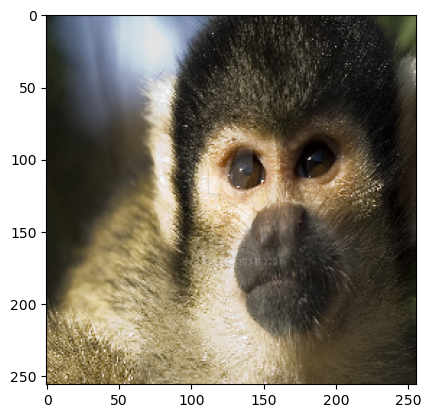

In [58]:
# Composition of transforms
composed = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize([image_base_size, image_base_size])  # Monkey images are not all square
])

# Training and validation datasets (different from dataloaders)
# Datasets gets passed into a dataloader
training_data = MonkeyDataset(
    annotations_file = "./kaggle/input/10-monkey-species/monkey_labels.txt",
    img_dir = "./kaggle/input/10-monkey-species/training/training",
    transform = composed
)

validation_data = MonkeyDataset(
    annotations_file = "./kaggle/input/10-monkey-species/monkey_labels.txt",
    img_dir = "./kaggle/input/10-monkey-species/validation/validation",
    transform = composed
)

# Dataloaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

# Peeking into the dataloader to get an example batch (train_dataloader is an iterator)
monkey_batch, train_labels = next(iter(train_dataloader))

# [[[image_channel1, image_channel2, image_channel3], ...]], [label1, ...]
print(f"Batch shape: {monkey_batch.shape}")
print(f"Image shape: {monkey_batch[0].shape}")

# Showing an example monkey
# https://stackoverflow.com/a/66641911
plt.imshow(monkey_batch[0].permute(1, 2, 0))
plt.show()

# Add batch of images to TensorBoard
writer.add_images("Example Batch", monkey_batch)

### Defining the Convolutional Neural Network

In [ ]:
class CNN(nn.Module):
    def __init__(self) -> None:
        # torch.utils.data.Dataset doesn’t define its own __init__ so by calling super().__init__() you are not performing any meaningful actions. In comparison, calling super().__init__() when subclassing torch.nn.Module is required to initialize the internal data structures for storing buffers, modules, etc.
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3)
        # self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)
        # self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # End up with size of 30 for the regular neural network
        self.full_con1 = nn.Linear(8*8*24, 1000)
        self.full_con2 = nn.Linear(1000, 100)
        self.full_con3 = nn.Linear(100, 10)
    
    def forward(self, x):
        # This whole first part is classification learning
        s = self.pool(F.leaky_relu(self.conv1(x)))  # Function takes in a tensor as input
        s = self.pool(F.leaky_relu(self.conv2(s)))
        s = self.pool(F.leaky_relu(self.conv3(s)))

        # Output channels * image width * image height
        s = torch.reshape(s, [-1, 8*8*24])
        s.size()
        # s = 

        # This whole second part is feature learning
        s = F.leaky_relu(self.full_con1(s))
        s = F.leaky_relu(self.full_con2(s))
        s = self.full_con3(s)

        return s

model = CNN().to(device)
print(model)

### Optimization code

In [ ]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

i = 0
# Training loop
for epoch in range(num_epochs):
    for iteration, (monkey, label) in enumerate(train_dataloader):
        monkey = monkey.to(device)
        label = label.to(device)
        # print(monkey.size(), label)

        # Forward pass
        # Pass on torch.Size([64, 3, 256, 256])
        pred = model.forward(monkey)
        # pred2 = model(monkey)
        # print(pred == pred2)

        # Clearing out optimizer grad
        optimizer.zero_grad()

        # Calculate loss
        # Target is a value between 0 and C
        # print(label)
        loss = loss_fn(pred, label)

        # Backward pass
        loss.backward()

        # Optimize (step)
        optimizer.step()

        print(f"Epoch:\t{epoch}\tIteration:\t{iteration}\tLoss:\t{loss}")
        writer.add_scalar("Loss/train", loss, i)
        writer.flush()
        i += 1

writer.close()

### Evaluating model accuracy with actual dataset

In [ ]:
with torch.no_grad():
    tot = 0
    right = 0
    for monkey, label in test_dataloader:  # Rename this to validation_dataloader later
        monkey = monkey.to(device)
        label = label.to(device)
        # print(monkey.size(), label) # Actual monkey, actual label

        guess = model(monkey)
        maxes, indicies = torch.max(guess, 1)
        
        right += sum(indicies == label)
        tot += indicies.shape[0]
        # print(indicies, label, torch.sum())

        # print(torch.sum)

print(f"Final Acc: {right/tot}")


### Random testing scrips down here

In [ ]:

e = pd.read_csv("./kaggle/input/10-monkey-species/monkey_labels.txt")
e.iloc[:,3]

tf = monkey_batch
# print(tf, type(tf), tf.size())

conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
pool = nn.MaxPool2d(kernel_size=3, stride=3)
conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3)
# self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)
# self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
# End up with size of 30 for the regular neural network
full_con1 = nn.Linear(8*8*24, 100)
full_con2 = nn.Linear(100, 50)
full_con3 = nn.Linear(50, 10)

# This whole first part is classification learning
s = pool(F.leaky_relu(conv1(tf)))  # Function takes in a tensor as input
print(type(s), s.size())
s = pool(F.leaky_relu(conv2(s)))
print(type(s), s.size())
s = pool(F.leaky_relu(conv3(s)))
print(type(s), s.size())

# Output channels * image width * image height
# s.view(-1, 30*30*24).size()
s = torch.reshape(s, [-1, 8*8*24])
s.size()
# s = 

# This whole second part is feature learning
s = F.leaky_relu(full_con1(s))
print(type(s), s.size())
s = F.leaky_relu(full_con2(s))
print(type(s), s.size())
s = full_con3(s)
print(type(s), s.size())


print(model.base.parameters())
print(model.classifier.parameters())
for p in model.parameters():
    print(p)